# Getting Started

MethodOfLines.jl is a Julia package for automated finite difference discretization of symbolicaly-defined PDEs in N dimensions. 

It uses symbolic expressions for systems of partial differential equations as defined with ModelingToolkit.jl, and `Interval` from DomainSets.jl to define the space(time) over which the simulation runs.

Allowable terms in the system include, but are not limited to

- Advection
- Diffusion
- Reaction
- Nonlinear Diffusion
- Spherical Laplacian
- Any Julia function of the symbolic parameters/dependent variables and other parameters in the environment that's defined on the whole domain. Note that more complicated functions may require registration with @register, see the ModelingToolkit.jl docs.

## Using the Brusselator PDE as an example

The Brusselator PDE is defined as follows:

```math
\begin{align}
\frac{\partial u}{\partial t} &= 1 + u^2v - 4.4u + \alpha(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) + f(x, y, t)\\
\frac{\partial v}{\partial t} &= 3.4u - u^2v + \alpha(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2})
\end{align}
```

where

```math
f(x, y, t) = \begin{cases}
5 & \quad \text{if } (x-0.3)^2+(y-0.6)^2 ≤ 0.1^2 \text{ and } t ≥ 1.1 \\
0 & \quad \text{else}
\end{cases}
```

and the initial conditions are

```math
\begin{align}
u(x, y, 0) &= 22\cdot (y(1-y))^{3/2} \\
v(x, y, 0) &= 27\cdot (x(1-x))^{3/2}
\end{align}
```

with the periodic boundary condition

```math
\begin{align}
u(x+1,y,t) &= u(x,y,t) \\
u(x,y+1,t) &= u(x,y,t)
\end{align}
```

on a timespan of ``t \in [0,11.5]``.

### Solving with MethodOfLines

With `ModelingToolkit.jl`, we first symbolically define the system, see also the docs for [`PDESystem`](https://docs.sciml.ai/ModelingToolkit/stable/systems/PDESystem/):

In [8]:
using ModelingToolkit, MethodOfLines, OrdinaryDiffEq, DomainSets

In [9]:
@parameters x y t
@variables u(..) v(..)
Dt = Differential(t)
Dx = Differential(x)
Dy = Differential(y)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

∇²(u) = Dxx(u) + Dyy(u)

brusselator_f(x, y, t) = (((x - 0.3)^2 + (y - 0.6)^2) <= 0.1^2) * (t >= 1.1) * 5.0

x_min = y_min = t_min = 0.0
x_max = y_max = 1.0
t_max = 11.5

α = 10.0

u0(x, y, t) = 22(y * (1-y))^(3 / 2)
v0(x, y, t) = 27(x * (1-x))^(3 / 2)

eq = [
    Dt(u(x,y,t)) ~ 1.0 + v(x,y,t) * u(x,y,t)^2 - 4.4 * u(x,y,t) + α * ∇²(u(x,y,t)) + brusselator_f(x,y,t),
    Dt(v(x,y,t)) ~ 3.4 * u(x,y,t) - v(x,y,t) * u(x,y,t)^2 + α * ∇²(v(x,y,t))
]

domains = [x ∈ Interval(x_min, x_max),
           y ∈ Interval(y_min, y_max),
           t ∈ Interval(t_min, t_max)]

# Periodic BCs
bcs = [u(x, y, 0) ~ u0(x, y, 0),
u(0, y, t) ~ u(1, y, t),
u(x, 0, t) ~ u(x, 1, t), v(x, y, 0) ~ v0(x, y, 0),
v(0, y, t) ~ v(1, y, t),
v(x, 0, t) ~ v(x, 1, t)]

@named pdesys = PDESystem(eq, bcs, domains, [x, y, t], [u(x, y, t), v(x, y, t)])

PDESystem
Equations: Equation[Differential(t)(u(x, y, t)) ~ 1.0 + 10.0(Differential(x)(Differential(x)(u(x, y, t))) + Differential(y)(Differential(y)(u(x, y, t)))) - 4.4u(x, y, t) + 5.0(((-0.3 + x)^2 + (-0.6 + y)^2) <= 0.010000000000000002)*(t >= 1.1) + (u(x, y, t)^2)*v(x, y, t), Differential(t)(v(x, y, t)) ~ 3.4u(x, y, t) + 10.0(Differential(x)(Differential(x)(v(x, y, t))) + Differential(y)(Differential(y)(v(x, y, t)))) - (u(x, y, t)^2)*v(x, y, t)]
Boundary Conditions: Equation[u(x, y, 0) ~ 22.0(y^1.5)*((1 - y)^1.5), u(0, y, t) ~ u(1, y, t), u(x, 0, t) ~ u(x, 1, t), v(x, y, 0) ~ 27.0((1 - x)^1.5)*(x^1.5), v(0, y, t) ~ v(1, y, t), v(x, 0, t) ~ v(x, 1, t)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 1.0), Symbolics.VarDomainPairing(y, 0.0 .. 1.0), Symbolics.VarDomainPairing(t, 0.0 .. 11.5)]
Dependent Variables: Num[u(x, y, t), v(x, y, t)]
Independent Variables: Num[x, y, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

### Method of lines discretization

Then, we create the discretization, leaving the time dimension undiscretized by supplying `t` as an argument.

In [10]:
N = 32
order = 2       # This may be increased to improve accuracy of some schemes

# Integers for x and y are interpreted as number of points. Use a Float to directtly specify stepsizes dx and dy.
discretization = MOLFiniteDifference([x => N, y => N], t, approx_order = order);

In [11]:
# Convert the PDE problem into an ODE problem
println("Discretization:")
@time prob = discretize(pdesys, discretization);

Discretization:


┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines C:\Users\jonas\.julia\packages\MethodOfLines\EiZyI\src\system_parsing\pde_system_transformation.jl:43


1235.237287 seconds (3.83 G allocations: 124.763 GiB, 2.77% gc time, 0.48% compilation time: 94% of which was recompilation)


### Solving problem

Now your problem can be solved with an appropriate ODE solver, or Nonlinear solver if you have not supplied a time dimension in the `MOLFiniteDifference` constructor. 

Include these solvers with `using OrdinaryDiffEq` or `using NonlinearSolve`, then call `sol = solve(prob, AppropriateSolver())` or `sol = NonlinearSolve.solve(prob, AppropriateSolver())`. For more information on the available solvers, see the docs for [`DifferentialEquations.jl`](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/), [`NonlinearSolve.jl`](http://docs.sciml.ai/NonlinearSolve/stable/solvers/NonlinearSystemSolvers/) and [SteadyStateDiffEq.jl](https://docs.sciml.ai/DiffEqDocs/stable/solvers/steady_state_solve/#SteadyStateDiffEq.jl). `Tsit5()` is a good first choice of solver for many problems. Some problems, particularly advection dominated ones, are better solved with [implicit DAE solvers](https://docs.sciml.ai/DiffEqDocs/stable/solvers/dae_solve/).

In [12]:
println("Solve:")
@time sol = solve(prob, TRBDF2(), saveat = 0.1);

Solve:
 23.152828 seconds (44.18 M allocations: 1.694 GiB, 9.84% gc time, 1.87% compilation time: 99% of which was recompilation)


### Extracting results

To retrieve your solution, for example for `u`, use `sol[u(x, y, t)]`. To get the independent variable axes, use `sol[t]`. For more information on the solution interface, see manual.

In [13]:
discrete_x = sol[x]
discrete_y = sol[y]
discrete_t = sol[t]

solu = sol[u(x, y, t)]
solv = sol[v(x, y, t)];

┌ Info: Saved animation to c:\Users\jonas\OneDrive\Desktop\Programming\Julia\Math_and_Numerical_Methods\Notebooks\Differential_Equations\PDEs\Method_of_Lines\Brusselator2Dsol_u.gif
└ @ Plots C:\Users\jonas\.julia\packages\Plots\UitjO\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\jonas\\OneDrive\\Desktop\\Programming\\Julia\\Math_and_Numerical_Methods\\Notebooks\\Differential_Equations\\PDEs\\Method_of_Lines\\Brusselator2Dsol_u.gif")
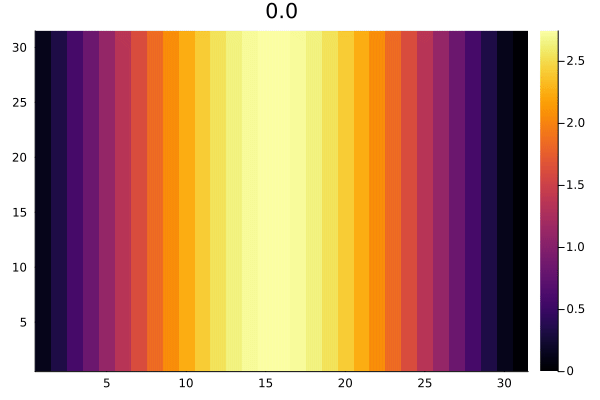

In [14]:
using Plots

anim = @animate for k in 1:length(discrete_t)
    heatmap(solu[2:end, 2:end, k], title = "$(discrete_t[k])") # 2:end since end = 1, periodic condition
end
gif(anim, "Brusselator2Dsol_u.gif", fps = 8)

## Check this out

Let's optimize the solution of a 2D Reaction-Diffusion PDE's discretization.
In its discretized form, this is the ODE:

```math
\begin{align}
du &= D_1 (A_y u + u A_x) + \frac{au^2}{v} + \bar{u} - \alpha u\\
dv &= D_2 (A_y v + v A_x) + a u^2 + \beta v
\end{align}
```

where ``u``, ``v``, and ``A`` are matrices. Here, we will use the simplified
version where ``A`` is the tridiagonal stencil ``[1,-2,1]``, i.e., it's the 2D
discretization of the Laplacian. 

The native code would be something along the
lines of:

In [ ]:
using DifferentialEquations, LinearAlgebra, BenchmarkTools

# Generate the constants
p = (1.0, 1.0, 1.0, 10.0, 0.001, 100.0)                                 # a, α, ubar, β, D1, D2
N = 100
Ax = Array(Tridiagonal([1.0 for i in 1:(N - 1)], [-2.0 for i in 1:N], [1.0 for i in 1:(N - 1)]))
Ay = copy(Ax)
Ax[2, 1] = 2.0
Ax[end - 1, end] = 2.0
Ay[1, 2] = 2.0
Ay[end, end - 1] = 2.0

function basic_version!(dr, r, p, t)
    a, α, ubar, β, D1, D2 = p
    u = r[:, :, 1]
    v = r[:, :, 2]
    Du = D1 * (Ay * u + u * Ax)
    Dv = D2 * (Ay * v + v * Ax)
    dr[:, :, 1] = Du .+ a .* u .* u ./ v .+ ubar .- α * u
    dr[:, :, 2] = Dv .+ a .* u .* u .- β * v
end

a, α, ubar, β, D1, D2 = p
uss = (ubar + β) / α
vss = (a / β) * uss^2
r0 = zeros(100, 100, 2)
r0[:, :, 1] .= uss .+ 0.1 .* rand.()
r0[:, :, 2] .= vss

prob = ODEProblem(basic_version!, r0, (0.0, 0.1), p);

In this version, we have encoded our initial condition to be a 3-dimensional array, with `u[:,:,1]` being the `A` part and `u[:,:,2]` being the `B` part.

In [ ]:
@btime solve(prob, Tsit5());

  123.806 ms (9253 allocations: 194.50 MiB)
